<a href="https://colab.research.google.com/github/NirajBagh/Drift-Detection-in-Industrial-Running-Machines/blob/main/Drift_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drift detection in industrial running machine

Change detection in industrial machines is crucial for several reasons, primarily to ensure the efficient operation, reliability, and safety of the equipment.Change detection helps in identifying abnormal patterns or deviations in machine behavior (e.g., vibration, temperature, or power consumption). Early detection allows operators to perform preventive maintenance, reducing downtime and preventing catastrophic failures.
Continuous monitoring and detecting changes in machine performance can signal when machinery is not operating at optimal efficiency. Adjustments can then be made to improve performance, saving energy and resources.
 Early detection of changes in machine performance ensures that corrective actions are taken before a machine failure occurs, minimizing production interruptions.

This notebook is intended to illustrate the change detection of industrial machinery by walking through a real life dataset of bearing vibration data.

# The Dataset

The dataset is sourced from the NASA repo https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/.

Dataset Citation : J. Lee, H. Qiu, G. Yu, J. Lin, and Rexnord Technical Services (2007). IMS, University of Cincinnati. "Bearing Data Set", NASA Ames Prognostics Data Repository (http://ti.arc.nasa.gov/project/prognostic-data-repository), NASA Ames Research Center, Moffett Field, CA

The Nasa data set describes a test-to-failure experiment. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point.

In [1]:
# Common imports
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/MyDrive/Machine life detection/2nd_test'
merged_data = pd.DataFrame()

# Looping over all files from 12th Feb to 19th Feb
for filename in os.listdir(data_dir):
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = pd.concat([merged_data, dataset_mean_abs], ignore_index=False)

# Renaming columns
merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
# Identifying index as datetime format
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

In [4]:
# Check - Begining of Data
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [5]:
# Check - End of Data
merged_data.tail()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 06:22:39,0.001168,0.000767,0.000716,0.001699


In [6]:
#Check Total Points
print(f'Total Data Points {merged_data.shape[0] + 1}')

Total Data Points 985


# Visualization of data

Text(2004-02-19 06:12:39, 0.3, 'Breakdown of Bearing 1')

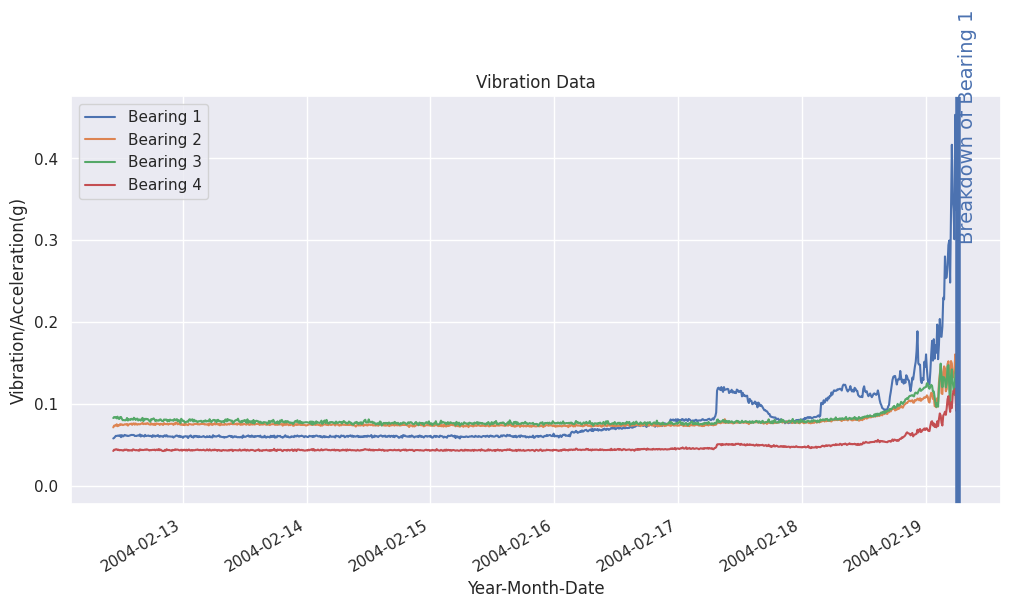

In [7]:
# Visualising Data
ax = merged_data.plot(figsize = (12,6), title="Vibration Data" , legend = True)
ax.set(xlabel="Year-Month-Date", ylabel="Vibration/Acceleration(g)")
plt.axvline(x='2004-02-19 06:12:39', linewidth=4, color='b', label ="Breakdown of Bearing 1")
plt.text('2004-02-19 06:12:39',0.3,'Breakdown of Bearing 1',rotation=90, fontsize=14, color='b')

# Change detection using NannyML

NannyML is an open-source python library for estimating post-deployment model performance (without access to targets), detecting data drift, and intelligently link data drift alerts back to changes in model performance. Built for data scientists, NannyML has an easy-to-use interface, interactive visualizations, is completely model-agnostic and currently supports all tabular use cases, classification and regression.

In [8]:
!pip install deepchecks

In [9]:
!pip show deepchecks scikit-learn

Name: deepchecks
Version: 0.18.1
Summary: Package for validating your machine learning model and data
Home-page: https://github.com/deepchecks/deepchecks
Author: deepchecks
Author-email: info@deepchecks.com
License: UNKNOWN
Location: /usr/local/lib/python3.10/dist-packages
Requires: beautifulsoup4, category-encoders, ipykernel, ipython, ipywidgets, jsonpickle, jupyter-server, matplotlib, numpy, pandas, plotly, PyNomaly, requests, scikit-learn, scipy, statsmodels, tqdm, typing-extensions
Required-by: 
---
Name: scikit-learn
Version: 1.3.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, category-encoders, deepchecks, fastai, imbalanced-learn, librosa, mlxtend, sklearn-pandas, yellowbrick


In [10]:
!pip install --upgrade scikit-learn deepchecks

  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)


In [11]:
!pip uninstall deepchecks scikit-learn -y

Found existing installation: deepchecks 0.18.1
Uninstalling deepchecks-0.18.1:
  Successfully uninstalled deepchecks-0.18.1
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2


In [12]:
!pip install deepchecks scikit-learn

  Using cached deepchecks-0.18.1-py3-none-any.whl.metadata (5.7 kB)
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
Using cached deepchecks-0.18.1-py3-none-any.whl (7.8 MB)
Using cached scikit_learn-1.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.8 MB)


# Create Referenace and Analysis Period

In [13]:
data=pd.read_csv("/content/merged_dataset_BearingTest_2.csv")

In [14]:
data.head()

,Unnamed: 0,Bearing 1,Bearing 2,Bearing 3,Bearing 4
0,2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
1,2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
3,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
4,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [15]:
data['timestamp']=data['Unnamed: 0']

In [16]:
# Dropping a column
data=data.drop(columns=['Unnamed: 0'])

In [17]:
reference_df1=data.iloc[0:100,:] # consider 1st 100 samples
analysis_df1=data.iloc[100:,:]

# Apply Univariate Drift Analysis

In [18]:
from deepchecks.tabular.checks import FeatureDrift
check = FeatureDrift()
result = check.run(train_dataset=reference_df1, test_dataset=analysis_df1)

deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuristically inferring categorical features in the data. 0 categorical features were inferred.
deepchecks - WARNING - Received a "pandas.DataFrame" instance. It is recommended to pass a "deepchecks.tabular.Dataset" instance by initializing it with the data and metadata, for example by doing "Dataset(dataframe, label=label, cat_features=cat_features)"
deepchecks - WARNING - It is recommended to initialize Dataset with categorical features by doing "Dataset(df, cat_features=categorical_list)". No categorical features were passed, therefore heuris

In [20]:
result

<!--
 ~ ----------------------------------------------------------------------------
 ~ Copyright (C) 2021-2023 Deepchecks (https://www.deepchecks.com)
 ~
 ~ This file is part of Deepchecks.
 ~ Deepchecks is distributed under the terms of the GNU Affero General
 ~ Public License (version 3 or later).
 ~ You should have received a copy of the GNU Affero General Public License
 ~ along with Deepchecks. If not, see .
 ~ ----------------------------------------------------------------------------
 ~
-->
<!DOCTYPE html>
 
 
 
 Feature Drift